# Anlysis for figure 3

## imports & installations

In [2]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import sys
import os
from itertools import groupby
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve
from sklearn import metrics
import scipy

warnings.simplefilter('ignore', pd.errors.DtypeWarning)
warnings.simplefilter("ignore")

sys.path.append(os.path.abspath('../..'))

import analysis.calc_single_cell_properties as calculator 
import analysis.calc_auc_over_time as auc_calculator 
import analysis.utils as utils
import data_layer.utils as data_utils
import model_layer.utils as model_utils
from configuration import consts, params

## data loading - differentiation scores dataframes

In [65]:
scores_df_s3 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (1,5) + fr"df_score_vid_num_S3.pkl",
                              scores_intensity_path=consts.intensity_model_path % (1,5) + fr"df_score_vid_num_S3.pkl")

scores_df_s2 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (1,5) + fr"df_score_vid_num_S2.pkl",
                              scores_intensity_path=consts.intensity_model_path % (1,5) + fr"df_score_vid_num_S2.pkl")

scores_df_s5 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (2,3) + fr"df_score_vid_num_S5.pkl",
                              scores_intensity_path=consts.intensity_model_path % (2,3) + fr"df_score_vid_num_S5.pkl")

scores_df_s1 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (2,3) + fr"df_score_vid_num_S1.pkl",
                              scores_intensity_path=consts.intensity_model_path % (2,3) + fr"df_score_vid_num_S1.pkl")

Calculate single cell properties

In [66]:
scores_df_s3 = calculator.get_properties(scores_df_s3, vid_name="S3", actin_vid_path=consts.vid_info_dict["3"]['actin_path'])
scores_df_s2 = calculator.get_properties(scores_df_s2, vid_name="S2", actin_vid_path=consts.vid_info_dict["2"]['actin_path'])
scores_df_s5 = calculator.get_properties(scores_df_s5, vid_name="S5", actin_vid_path=consts.vid_info_dict["5"]['actin_path'])
scores_df_s1 = calculator.get_properties(scores_df_s1, vid_name="S1", actin_vid_path=consts.vid_info_dict["1"]['actin_path'])

## Cellular properties overview

the displayed data: 

S3 video, (Erki, 211212_CD7_ERK_P38), S2 video, (DMSO, 211212_CD7_ERK_P38), S6 video, (Erki + P38, 211212_CD7_ERK_P38), S8 video, (P38, 211212_CD7_ERK_P38)  
as the test set data. the scores are based on a model that was trained on videos s1 (DMSO,211006_CD7_DMSO_ERKi) & s5 (ERKi, 211006_CD7_DMSO_ERKi).
The followiing displayed trackes are *all* the manually-tracked cells.

In [7]:
def plot_property_over_time(properties_df_lst, features_list, time=(0,25)):
    sns.set_style("whitegrid")
    dfs = list(map(lambda x: x[0], properties_df_lst))
    labels = list(map(lambda x: x[1], properties_df_lst))
    colors = list(map(lambda x: x[2], properties_df_lst))

    tot = len(features_list)
    cols = 2
    rows = tot // cols
    if tot % cols != 0:
        rows += 1
    position = range(1, tot + 1)
    fig = plt.figure(1, figsize=(14,14))

    for k in range(tot):
        f = features_list[k]
        ax = fig.add_subplot(rows, cols, position[k])
        for df, label, color in zip(dfs, labels, colors):   

            df = df[(df["time"]>= time[0]) & (df["time"]< time[1])]
            df = df.sort_values("time")
            mean = round(df.dropna(subset=[f]).groupby("time")[f].mean(), 2).rolling(1).mean()
            std = round(df.dropna(subset=[f]).groupby("time")[f].std(), 2).rolling(1).mean()
            ax.plot(mean, color=color, label=label)
            plt.fill_between(df["time"].unique()[:len(mean)], mean - std, mean + std, alpha=0.4, color=color, label=label)
            
            ax.axvspan(6, 13, alpha=0.3, color='lightgray')
            ax.axvline(6, color='gray', linestyle='dashed')
            ax.axvline(13, color='gray', linestyle='dashed')
            
            ax.set_ylabel(f"{f}")
            ax.set_xlabel(f"time")
            ax.set_title(f'{f} over time')
            ax.grid(False)
            ax.legend()
            
    plt.savefig(consts.storage_path + f"eps_figs/property_over_time {str(labels)}.eps", format="eps")

time = (4,15)  
features_list = ["local density", "speed", "mean", "persistence"]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


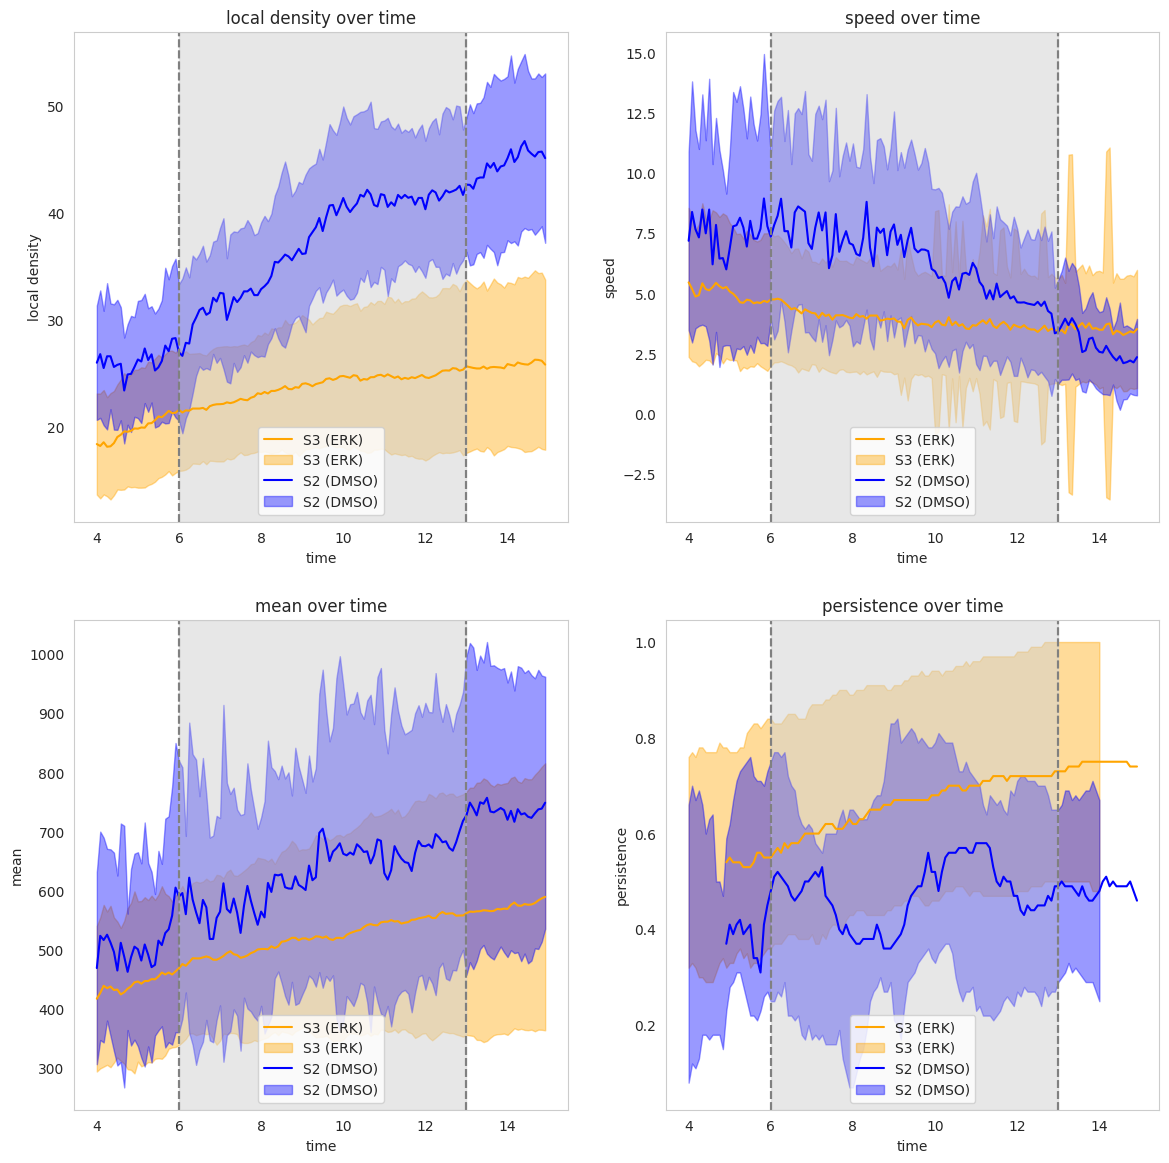

In [8]:
data = [(scores_df_s3, "S3 (ERK)","orange") ,(scores_df_s2, "S2 (DMSO)", "blue")]
plot_property_over_time(data, features_list, time=time)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


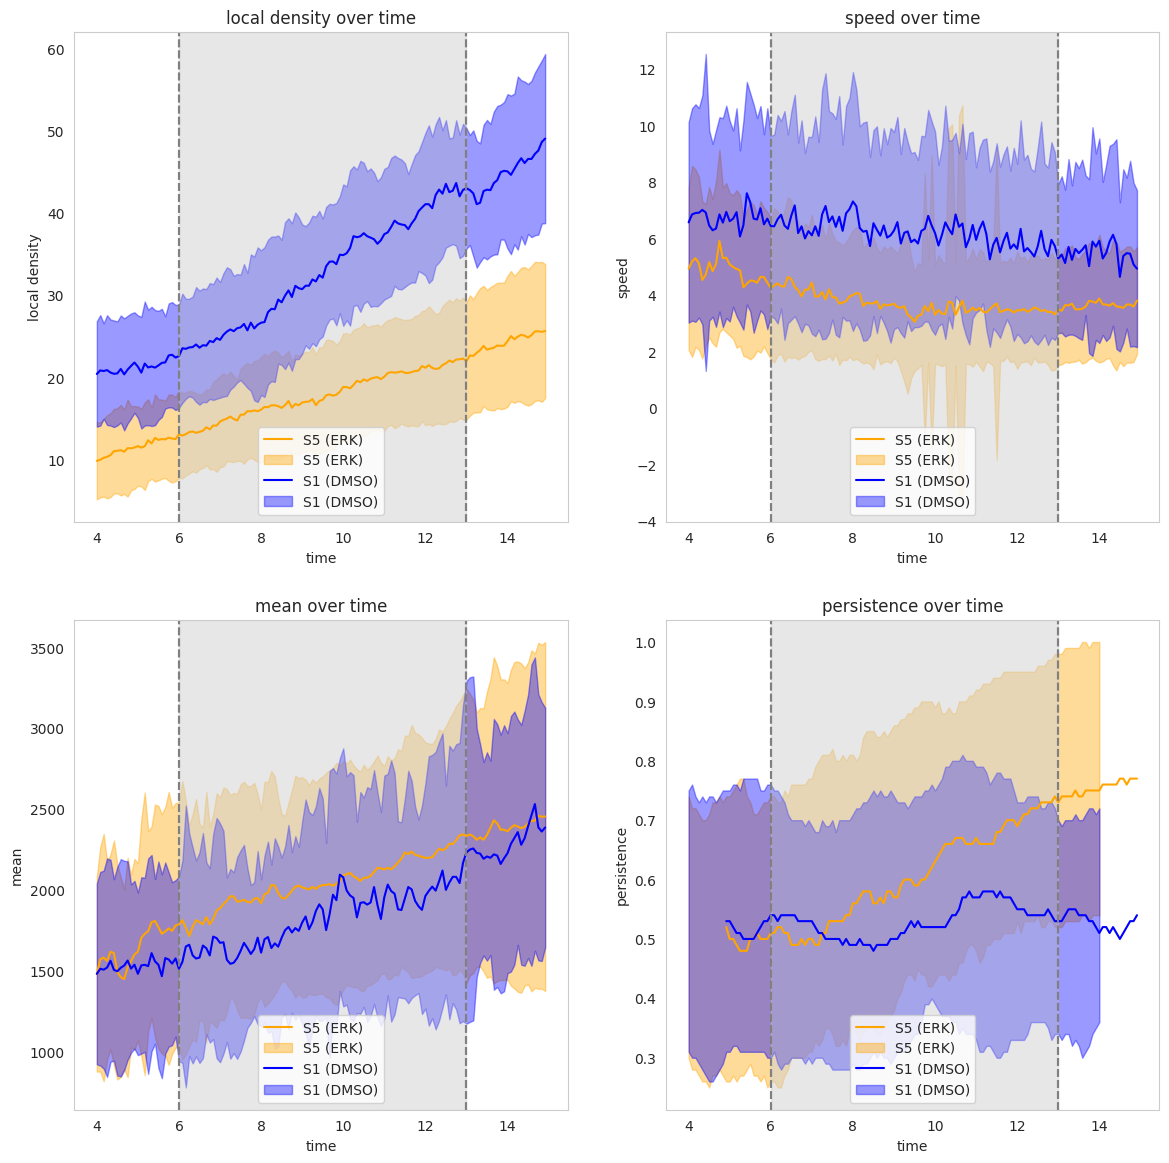

In [9]:
data = [(scores_df_s5, "S5 (ERK)","orange") ,(scores_df_s1, "S1 (DMSO)", "blue")]
plot_property_over_time(data, features_list, time=time)

the displayed data: 

S1 video, (DMSO,211006_CD7_DMSO_ERKi), S5 video, (Erki,211006_CD7_DMSO_ERKi)
as the test set data. the scores are based on a model that was trained on videos S3 (Erki, 211212_CD7_ERK_P38) & S2 (DMSO, 211212_CD7_ERK_P38).
The followiing displayed trackes are *all* the manually-tracked cells.

In [176]:
df = scores_df_s3
print(df["Spot track ID"].nunique())
new_df = data_utils.remove_short_tracks(df.copy(), 1)
print(new_df["Spot track ID"].nunique())

675
675


In [206]:
from sklearn.preprocessing import StandardScaler

def create_one_feature_df(data, target, features_lst, arg_scaler=None):
    data = data.sort_values("time")
    cols = features_lst.copy()
    cols.extend(["Spot frame", "Spot track ID"])
    df = data[cols]        
    for f in features_lst:        
        data_lst = df.groupby(['Spot track ID'])[f].apply(lambda x: list(x.rolling(30).mean()))
        df[f'moving_{f}'] = df.groupby(['Spot track ID'])['Spot track ID'].transform(lambda x: data_lst[x.iloc[0]])
        
        if arg_scaler:
            scaler =  StandardScaler()
            df[f'moving_{f}'] = scaler.fit_transform(np.array(df[f].values).reshape(-1, 1))
    df["target"] = target
    return df

def create_rf(dir_path, features_lst, cols, train_con, train_dif, test_con, test_dif, scaler):    
    df_train_con = create_one_feature_df(train_con, 0, features_lst, scaler).dropna(subset=cols)
    df_test_con = create_one_feature_df(test_con, 0, features_lst, scaler).dropna(subset=cols)
    df_test_dif = create_one_feature_df(test_dif, 1, features_lst, scaler).dropna(subset=cols)
    df_train_dif = create_one_feature_df(train_dif, 1, features_lst, scaler).dropna(subset=cols)
    
    train = model_utils.concat_dfs(df_train_dif[cols], df_train_con[cols], diff_t_window=params.diff_window, con_t_windows=params.con_window)
    test = model_utils.concat_dfs(df_test_dif[cols], df_test_con[cols], diff_t_window=params.diff_window, con_t_windows=params.con_window)

    X_train, y_train = pd.DataFrame(train.drop(columns=['Spot frame', 'Spot track ID', 'target'])), train["target"]
    X_test, y_test = pd.DataFrame(test.drop(columns=['Spot frame', 'Spot track ID', 'target'])), test["target"]
    
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    
    print("y_test: ", len(y_test))
    auc = utils.evaluate_model(clf, X_test, pd.DataFrame(y_test), features_lst, None, None, plot_auc_over_t=False)    
    data_utils.save_data(dir_path, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, clf=clf)
    
    return [df_test_con, df_test_dif, clf, auc]

In [215]:
path = consts.storage_path + "/15-12-2022-actin_intensity local dens-False, s1, s5 train [130, 160] diff window win size 16/track len 30, impute_func-ImputeAllData_impute_zeroes reg MeanOpticalFlowReg_/S3_properties_MeanOpticalFlowReg_.pkl"
props_s3 = pickle.load(open(path, 'rb'))
props_s3["Spot track ID"].nunique()
ids = props_s3["Spot track ID"].unique()

In [214]:
scores_df_s3["Spot track ID"].nunique()

675

<AxesSubplot: >

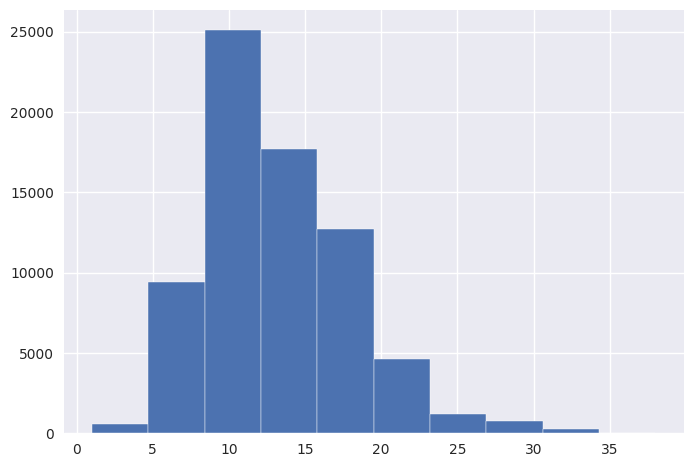

In [219]:
props_s3["local_density"].hist()

In [223]:
from data_layer.features_calculator import LocalDensityFeaturesCalculator

def get_local_density(scores_df, vid_num, local_den_dist=50):
    """
    Local density: the number of nuclei within a radius of 50 µm around the cell.
    :param scores_df: (pd.DataFrame) differntiation scores by motility & actin intensity models
    :param vid_num: (int) number of the data's video stage (1/2/3/5/6/8)
    :return: (pd.DataFrame) scores with persistence values for each timepoint.
    """

    def calc_local_den(track, vid_num):
        track_id = track['Spot track ID'].max()
        local_den_lst = list(calculator.get_single_cell_measures(track_id, track, None, None, vid_num)["local density"])
        return local_den_lst

    def map_local_den(x, persistence_lst):
        return persistence_lst[x.iloc[0]]

    calculator = LocalDensityFeaturesCalculator()
    calculator.neighboring_distance = local_den_dist
    print(calculator.neighboring_distance)
    local_den_lst = scores_df.groupby(['Spot track ID']).apply(lambda x: calc_local_den(x, vid_num))
    scores_df["local density"] = scores_df.groupby(['Spot track ID'])['Spot track ID'].transform(
        lambda x: map_local_den(x, local_den_lst))

    return scores_df

scores_df_s3_25 = get_local_density(scores_df_s3.copy(), 3, 25)
scores_df_s3_30 = get_local_density(scores_df_s3.copy(), 3, 30)
scores_df_s3_35 = get_local_density(scores_df_s3.copy(), 3, 35)
scores_df_s3_40 = get_local_density(scores_df_s3.copy(), 3, 40)
scores_df_s3_45 = get_local_density(scores_df_s3.copy(), 3, 45)

25
30
35
40
45


In [229]:
scores_df_s3_50 = get_local_density(scores_df_s3.copy(), 3, 50)

50


In [232]:
scores_df_s2_50 = get_local_density(scores_df_s2.copy(), 2, 50)
scores_df_s1_50 = get_local_density(scores_df_s1.copy(), 1, 50)
scores_df_s5_50 = get_local_density(scores_df_s5.copy(), 5, 50)

50
50
50


<AxesSubplot: >

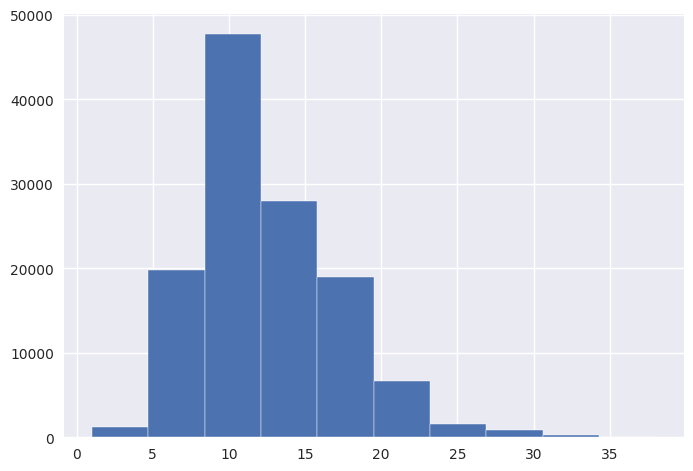

In [230]:
scores_df_s3_50["local density"].hist() 

['local density']
size of diff_df:  (282, 3)
size of con_df:  (511, 3)
size of diff_df:  (590, 3)
size of con_df:  (191, 3)
y_test:  781
Evaluation metrics for ['local density'] based model, tested on videos (sNone, sNone):
accuracy: 0.438
specificity: 0.901
sensitivity (recall): 0.288
precision: 0.899
AUC: 0.594


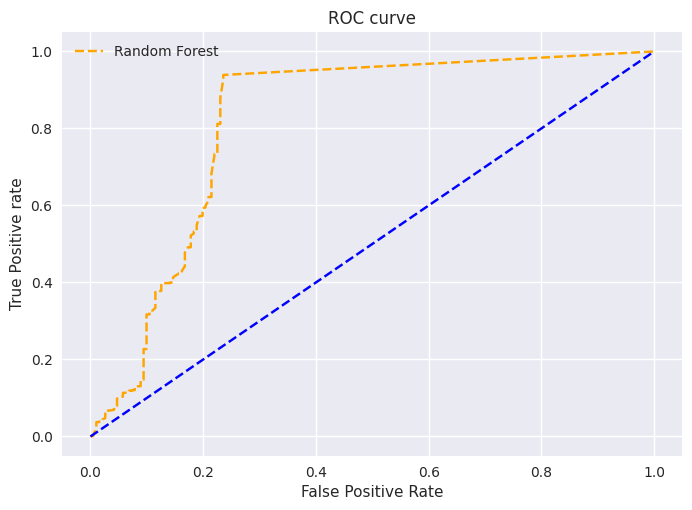

size of diff_df:  (590, 3)
size of con_df:  (191, 3)
size of diff_df:  (282, 3)
size of con_df:  (511, 3)
y_test:  793
Evaluation metrics for ['local density'] based model, tested on videos (sNone, sNone):
accuracy: 0.625
specificity: 0.706
sensitivity (recall): 0.479
precision: 0.474
AUC: 0.593


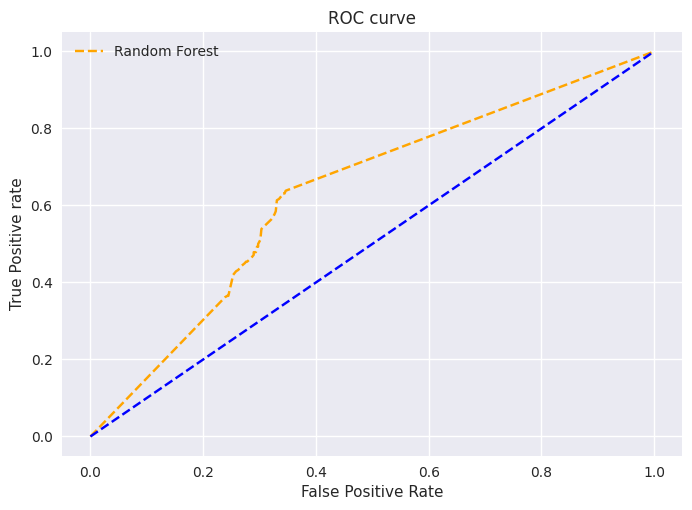

<Figure size 800x550 with 0 Axes>

In [231]:
def run_clf_model(features_lst, scaler, avg_score=False):
    cols = [f'moving_{f}' for f in features_lst]
    cols.extend([ "Spot frame", "Spot track ID"])
    os.makedirs(consts.storage_path + "simple_classifiers", exist_ok=True)
    for con_train_n, diff_train_n, con_test_n, diff_test_n in [("s1", "s5", "s2", "s3"), ("s2", "s3", "s1", "s5")]:
        dir_path = consts.storage_path + fr"simple_classifiers/test {con_test_n}, {diff_test_n} scaler={scaler},{str(features_lst)}"
        os.makedirs(dir_path, exist_ok=True)
        
        train_con, train_dif = scores_df_dict[con_train_n], scores_df_dict[diff_train_n]
        test_con, test_dif = scores_df_dict[con_test_n], scores_df_dict[diff_test_n]
        
        aucs_lst = []
        feature_df_test_con, feature_df_test_dif, clf, auc = create_rf(dir_path, features_lst, cols, train_con, train_dif, test_con, test_dif, scaler)
        aucs_lst.append(auc)
        
        if avg_score:
            df_score_con = model_utils.calc_state_trajectory(feature_df_test_con[cols].dropna(), clf, n_frames=260)
            df_score_dif = model_utils.calc_state_trajectory(feature_df_test_dif[cols].dropna(), clf, n_frames=260)
            pickle.dump(df_score_con, open(dir_path + f"/df_prob_vid_num={con_test_n}.pkl", 'wb'))
            pickle.dump(df_score_dif, open(dir_path + f"/df_prob_vid_num={diff_test_n}.pkl", 'wb'))
            
    return np.mean(aucs_lst), np.std(aucs_lst)
lag1=1
lag2=1
scores_df_dict = {"s1": data_utils.remove_short_tracks(scores_df_s1.copy(), 1), 
                  "s2": data_utils.remove_short_tracks(scores_df_s2.copy(), 1), 
                  "s3": scores_df_s3_50, 
                  "s5": data_utils.remove_short_tracks(scores_df_s5.copy(), 1)}
lsts = [["local density"], ] #["speed"], ["mean"], ["persistence"], ["speed", "mean", "persistence", "local density"]]
aucs_standard = {}
aucs_none = {}
for lst in lsts:
    print(lst)
    aucs_none[str(lst)] = run_clf_model(lst, scaler=None, avg_score=False)
# size of diff_df:  (189, 3)
# size of con_df:  (322, 3)
# size of diff_df:  (449, 3)
# size of con_df:  (150, 3)



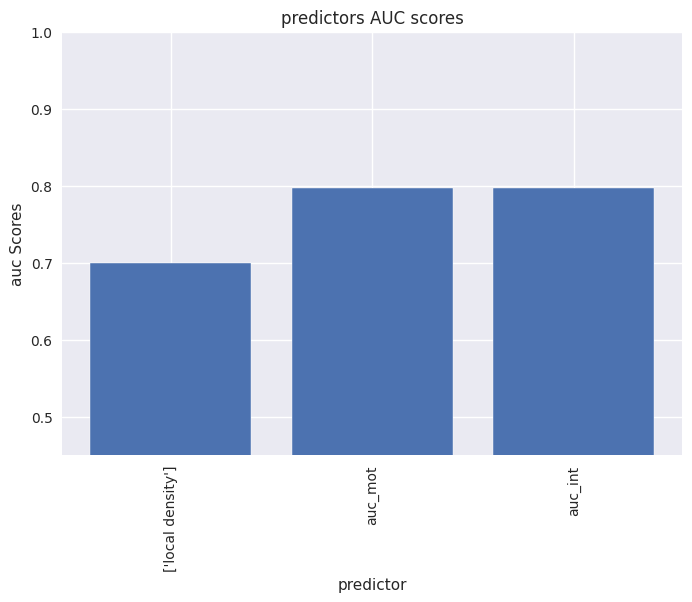

In [197]:
def get_mean_auc(model_path1, model_path2):
    clf, _, x_test, _, y_test = data_utils.load_data(model_path1, load_clf=True, load_x_train=False, load_x_test=True, load_y_test=True, load_y_train=False)
    pred = clf.predict(x_test[clf.feature_names_in_])
    fpr, tpr, thresholds = roc_curve(y_test["target"], pred, pos_label=1)
    auc1 = round(metrics.auc(fpr, tpr), 3)
    
    clf, _, x_test, _, y_test = data_utils.load_data(model_path2, load_clf=True, load_x_train=False, load_x_test=True, load_y_test=True, load_y_train=False)
    pred = clf.predict(x_test[clf.feature_names_in_])
    fpr, tpr, thresholds = roc_curve(y_test["target"], pred, pos_label=1)
    auc2 = round(metrics.auc(fpr, tpr), 3)
    
    return np.mean([auc1, auc2]), np.std([auc1, auc2])


path_mot_1 = consts.motility_model_path % (1,5)
path_mot_2 = consts.motility_model_path % (2,3)
mean_auc_mot, std_auc_mot = get_mean_auc(path_mot_1, path_mot_2)


path_int = consts.intensity_model_path % (1,5)
path_int = consts.intensity_model_path % (2,3)
mean_auc_int, std_auc_int = get_mean_auc(path_mot_1, path_mot_2)



aucs = aucs_none.copy()
aucs["auc_mot"] = (mean_auc_mot, std_auc_mot)
aucs["auc_int"] = (mean_auc_int, std_auc_int)

N = len(aucs)
ind = np.arange(N) 
  
xvals = np.array(list(aucs.values()))[:,0]
bar1 = plt.bar(ind, xvals)
  
plt.xlabel("predictor")
plt.ylabel('auc Scores')
plt.ylim((0.45,1))
plt.title("predictors AUC scores")

plt.savefig(consts.storage_path + f"eps_figs/simple_clfs_comaperison.eps", format="eps")
plt.xticks(ind, list(aucs.keys()),rotation = 90)
plt.show()

In [15]:
path = consts.storage_path + fr"simple_classifiers/test s2, s3 scaler=None,%s/df_prob_vid_num=s3.pkl"

scores_local_den_s3 = pickle.load(open(path % ["local density"], 'rb'))
scores_speed_s3 = pickle.load(open(path % ["speed"], 'rb')) 
scores_mean_s3 = pickle.load(open(path % ["mean"], 'rb'))  
scores_persistence_s3 = pickle.load(open(path % ["persistence"], 'rb'))  
scores_features_s3 = pickle.load(open(path % ["speed", "mean", "persistence", "local density"], 'rb'))   

df_score_dif_mot = pickle.load(open(consts.motility_model_path % (1,5) + fr"df_score_vid_num_S3.pkl", 'rb'))  
df_score_dif_int = pickle.load(open(consts.intensity_model_path % (1,5) + fr"df_score_vid_num_S3.pkl", 'rb'))  

local density - median:  -0.09 size of data:  675
speed - median:  -0.03 size of data:  675
mean - median:  -0.15 size of data:  580
persistence - median:  0.19 size of data:  631
featurs - median:  -0.11 size of data:  530
motility - median:  0.51 size of data:  675
intensity - median:  0.7 size of data:  675


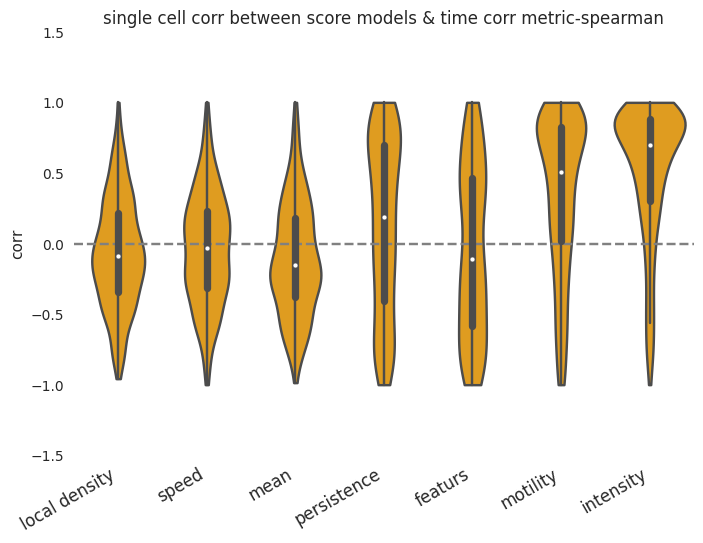

In [16]:
def plot_something(data_list, modalities, color, corr_metric, ylim=((-1.5,1.5)), time=(6,13), fig_name=None):
    sns.set_style("white")
    corrs = []
    for df, modality in zip(data_list, modalities):
        df = data_utils.convert_score_df(df, modality)
        corr = utils.get_correlation_coefficients(df, time, f"score_{modality}", "time", rolling_w=5, corr_metric="spearman")
        corrs.append(corr[~np.isnan(corr)])    
        print(modality, "- median: ", round(np.nanmedian(corr),2), "size of data: ", len(corr))
          
    plt.axhline(0, color='gray', linestyle='dashed')
    df = pd.DataFrame()
    for i, col in enumerate(modalities):
        tmp_df = pd.DataFrame({col:corrs[i]})
        df = df.append(tmp_df.dropna(), ignore_index=True)
    sns.violinplot(data=df, color=color, cut=0, inner='box')

    
    plt.title(f'{modality} over time')
    plt.xticks(rotation=30, ha='right', fontsize='large')
    plt.ylabel("corr")
    plt.title(f"single cell corr between score models & time corr metric-{corr_metric}")
    plt.ylim(ylim)
    fig_name = f"single cell correlation time & score cls" if fig_name is None else fig_name
    plt.savefig(consts.storage_path + f"eps_figs/" + fig_name + f" compare metric={corr_metric}.eps", format="eps")
    plt.show()
    
plot_something([scores_local_den_s3, scores_speed_s3, scores_mean_s3, scores_persistence_s3, scores_features_s3, df_score_dif_mot, df_score_dif_int], 
               ["local density", "speed", "mean", "persistence", "featurs", "motility", "intensity"],
               "orange", "spearman", time=(6,13))